# Calculate and mean gene expression across cells in Forskolin v. cells in DMSO Figure S4C

In [1]:
%matplotlib inline

import os

import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.io
import matplotlib.pyplot as plt

## Import/Export Directories

In [2]:
# for AnnData objects from Scanpy:
# These AnnData objects contain output from the filtering and QC notebook
# Containing unnormalized counts matrices with low-count barcodes removed
h5ad_dir = '_h5ad_files'
os.makedirs(h5ad_dir, exist_ok=True)

# for plots from matplotlib, seaborn, helper functions plots:
plot_dir = '_plots_avg_gene_exp_between_treatment'
os.makedirs(plot_dir, exist_ok=True)

## Plotting Settings

In [3]:
# scanpy
sc.set_figure_params(scanpy=True, dpi=80, dpi_save=150, 
                     frameon=True, vector_friendly=True, fontsize=14, 
                     figsize=None, color_map=None, format='eps', 
                     facecolor=None, transparent=False, ipython_format='png2x')

sc.settings.verbosity = 2  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=150)  # low dpi (dots per inch) yields small inline figure

In [4]:
# matplotlib params:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rc('font', size=12)
plt.rcParams['pdf.fonttype'] = 42

# seaborn
sns.set(context='notebook', style='white', font_scale=0.5)

## Load single cell data

In [5]:
adata = sc.read(f'{h5ad_dir}/adata_merged_annotated_perturbations.h5ad')

In [6]:
# optionally restrict to cells which have at least 1000 counts

### Split the data into experiments

In [7]:
adata_12 = adata[adata.obs['duration'].isin(['12h'])]

### Split the experiment data by treatment condition

In [8]:
adata_12_dmso = adata_12[adata_12.obs['treatment'].isin(['DMSO'])] # all rep. cells have total counts above 1000

In [9]:
adata_12_forsk = adata_12[adata_12.obs['treatment'].isin(['Forskolin'])]

In [10]:
# count only the 845 cells that meet the criteria for abundance plots (lose 90 cells for more conservative measurement)
adata_12_forsk = adata_12_forsk[adata_12_forsk.obs.loc[adata_12_forsk.obs['n_counts'] >= 1000].index] 

## Plot average gene expression between Forskolin and DMSO - Figure S4C

In [11]:
def make_mean_barplot(gene, adata_ctrl, adata_perturb, ctrl_name, perturb_name, plot_dir):
    # make a bar plot of the means of the CP10K gene expression between perturbation and control
    
    
    
    gene_perturb_sparse = adata_perturb.raw[:, f'{gene}'].X/adata_perturb.raw.X.sum(axis=1)*1e4
    
    gene_perturb = pd.DataFrame(gene_perturb_sparse).rename(columns={0:f'{perturb_name} {gene}'})
    gene_perturb_mean = gene_perturb.mean()
    gene_perturb_SE = gene_perturb.std()/np.sqrt(adata_perturb.X.shape[0])
    
    gene_ctrl_sparse = adata_ctrl.raw[:, f'{gene}'].X/adata_ctrl.raw.X.sum(axis=1)*1e4
    
    gene_ctrl = pd.DataFrame(gene_ctrl_sparse).rename(columns={0:f'{ctrl_name} {gene}'})
    gene_ctrl_mean = gene_ctrl.mean()
    gene_ctrl_SE = gene_ctrl.std()/np.sqrt(adata_ctrl.X.shape[0])
    
    genes_to_plot_cp10K_gene_mean = pd.concat([gene_ctrl_mean, gene_perturb_mean])
    #print(genes_to_plot_cp10K_gene_mean)
    
    new_df = pd.DataFrame(genes_to_plot_cp10K_gene_mean).rename(columns={0: 'mean'})
    SE_all = pd.concat([gene_ctrl_SE, gene_perturb_SE], axis=0)
    SE_all = pd.DataFrame(SE_all).rename(columns = {0:'SE'})
    
    df_to_plot = new_df.merge(SE_all, on=SE_all.index).rename(columns={'key_0':'treatment_duration_gene'})
    
    df_to_plot.index = df_to_plot['treatment_duration_gene']
    del df_to_plot['treatment_duration_gene']

    ax = df_to_plot.plot(kind='barh', y='mean', xerr=df_to_plot['SE'], legend=False) 
    fig = ax.get_figure()

    fig.tight_layout()
    fig.savefig(f'{plot_dir}/{gene}_{ctrl_name}_{perturb_name}_mean_exp_barplot.eps')
    
    return fig, df_to_plot

### Plot for Lgr5, repeat for other marker genes; corroborates abundance changes in Figure 6B

(<Figure size 600x600 with 1 Axes>,
                              mean        SE
 treatment_duration_gene                    
 DMSO lgr5                0.502163  0.044494
 Forskolin lgr5           0.294761  0.032553)

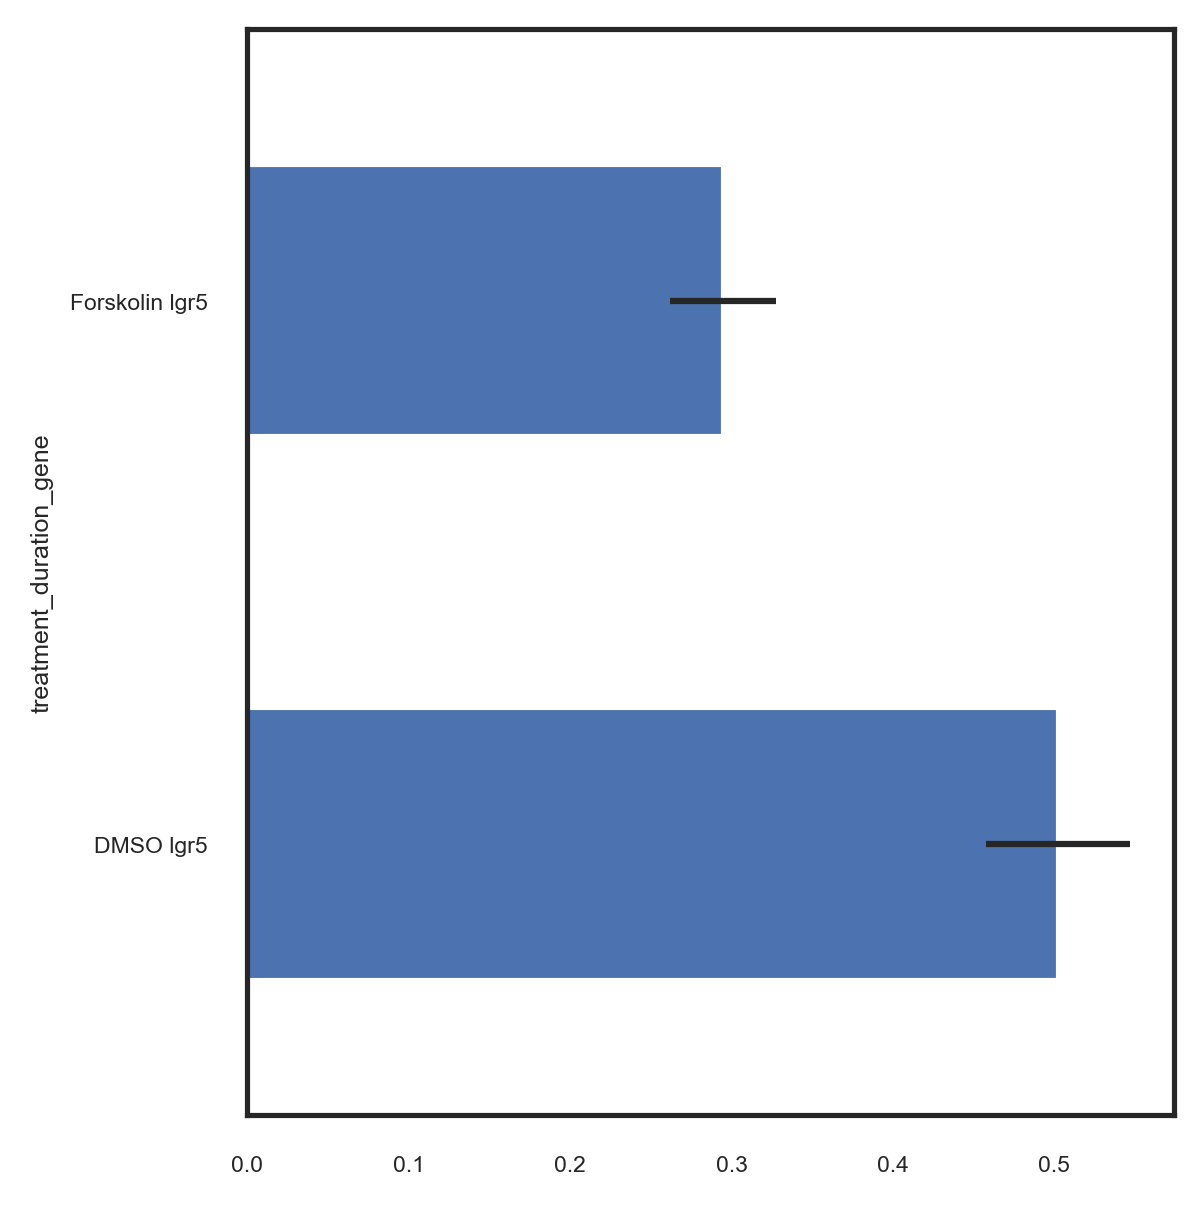

In [12]:
make_mean_barplot('lgr5', adata_12_dmso, adata_12_forsk, 'DMSO', 'Forskolin', plot_dir)